### Introduction
This file contains the thorough implementation of alternating renew reward process on the nba games' winning probability prediction. In this project, I collected data of the first 452 NBA regular season games. I will use these data to contruct a model to predict real time winning probability.

### Data collection
All the data are from the ESPN play-by-play game statistics. I build a scraper to collect all the useful information

In [3]:
import requests
import numpy as np
import pandas as pd
import datetime
from bs4 import BeautifulSoup
import time
from scipy.stats import gamma
import scipy.stats as stats 
import matplotlib.pyplot as plt

The following is the scraper used to scrap a single game's play-by-play data.

In [2]:
def scrap_pbp_by_espnid(id):
    url = f"https://www.espn.com/nba/playbyplay/_/gameId/{id}"
    s = requests.get(url).text
    soup = BeautifulSoup(s)
    lis = soup.find_all("li", attrs = {"class":"accordion-item"})
    all_quaters = pd.DataFrame()
    for k in range(1, len(lis)):
        table = lis[k].find("table")
        team_names = pd.Series([i.find("img")["src"] for i in table.find_all("td", attrs = {"class":"logo"})])
        team_names_ser = team_names.str.extract("\/([a-z]+).png")[0].str.upper()
        game_details = pd.Series([i.text for i in table.find_all("td", attrs = {"class":"game-details"})])
        time_ser = pd.Series([i.text for i in table.find_all("td", attrs = {"class":"time-stamp"})])
        seconds = time_ser.str.split(":").apply(lambda x: int(x[0])*60+float(x[1]) if len(x) == 2 else float(x[0]))
        if k >= 5:
            game_time = 2880 + 300*(k-4) - seconds
        else:
            game_time = 720*k - seconds
        home_scores = pd.Series([int(i.text.split("-")[1]) for i in table.find_all("td", attrs = {"class":"combined-score"})])
        away_scores = pd.Series([int(i.text.split("-")[0]) for i in table.find_all("td", attrs = {"class":"combined-score"})])
        cleaned_table = pd.DataFrame({"Team":team_names_ser, "Game_details":game_details, "Time_left":time_ser, "Game_time":game_time, "Away_score":away_scores, "Home_score":home_scores})
        all_quaters = pd.concat([all_quaters, cleaned_table])
    return all_quaters

The function below is used to find the home team and away team given a game id.

In [3]:
def get_home_away(id):
    url = f"https://www.espn.com/nba/playbyplay/_/gameId/{id}"
    s = requests.get(url).text
    soup = BeautifulSoup(s)
    away_abbrev_name = soup.find_all("span", attrs = {"class":"abbrev"})[0].text
    home_abbrev_name = soup.find_all("span", attrs = {"class":"abbrev"})[1].text
    return away_abbrev_name, home_abbrev_name

This function below is used to identify the "end" of a possession. There are four ways that a possession can end.
1. The team makes a shot
2. The team makes a turnover
3. The team misses a shot and the other team gets the defensive rebound
4. The quater ends

In [4]:
def identify_pos(x):
    tag = x.split("@")[0]
    details = x.split("@")[1]
    out = ""
    if ("defensive rebound" in details) or ("defensive team rebound" in details):
        out = tag + "-"
    elif "makes free throw 1 of 2" in details:
        out = "null"
    elif "makes free throw 1 of 3" in details:
        out = "null"
    elif "makes free throw 2 of 3" in details:
        out = "null"
    elif "traveling" in details:
        out = tag
    elif "turnover" in details:
        out = tag
    elif "makes" in details:
        out = tag
    elif "End" in details:
        out = "End"
    elif "bad pass" in details:
        out = tag
    else:
        out = "null"
    return out

The function below is used to transform the ESPN play-by-play data to possession data.

In [5]:
def raw_pos_data(id):
    df_example = scrap_pbp_by_espnid(id)
    away_team, home_team = get_home_away(id)
    df_example1 = df_example.assign(util_col = df_example["Team"] + "@" + df_example["Game_details"])
    df_example2 = df_example1.assign(pos = df_example1["util_col"].apply(identify_pos))
    df_example3 = df_example2.assign(pos1 = df_example2["pos"].replace({(away_team+"-"):home_team,(home_team+"-"):away_team}))
    df_example4 = df_example3.reset_index(drop = True)
    to_change = list(df_example4["pos1"])
    to_change[0] = "START"
    df_example4["pos2"] = to_change
    df_example5 = df_example4[["Game_details", "Game_time", "Away_score", "Home_score", "pos2"]]
    df_example6 = df_example5[df_example5["pos2"] != "null"]
    df_example7 = df_example6.drop_duplicates(subset="Game_time", keep='last', inplace=False)
    df_example7["sum_score"] = df_example7["Away_score"] + df_example7["Home_score"]
    time_diff = df_example7["Game_time"].diff()
    score_diff = df_example7["sum_score"].diff()
    pos_name = df_example7["pos2"].iloc[1:]
    df_example8 = pd.DataFrame({"Team":pos_name, "Time":time_diff, "Score":score_diff})
    df_example9 = df_example8[(~pd.isnull(df_example8["Team"])) & (df_example8["Team"] != "End")]
    df_example9["Team"] = df_example9["Team"].apply(lambda x: x+"*" if x == home_team else x)
    return df_example9

Only the team's possession data is not enough, We also need the team's opponent possession data in order to build a thorough model. The function below is to tranform the ESPN play-by-play data to opponent possession data.

In [6]:
def oppp(id):
    df_example = scrap_pbp_by_espnid(id)
    away_team, home_team = get_home_away(id)
    df_example1 = df_example.assign(util_col = df_example["Team"] + "@" + df_example["Game_details"])
    df_example2 = df_example1.assign(pos = df_example1["util_col"].apply(identify_pos))
    df_example3 = df_example2.assign(pos1 = df_example2["pos"].replace({(away_team+"-"):home_team,(home_team+"-"):away_team}))
    df_example4 = df_example3.reset_index(drop = True)
    to_change = list(df_example4["pos1"])
    to_change[0] = "START"
    df_example4["pos2"] = to_change
    df_example5 = df_example4[["Game_details", "Game_time", "Away_score", "Home_score", "pos2"]]
    df_example6 = df_example5[df_example5["pos2"] != "null"]
    df_example7 = df_example6.drop_duplicates(subset="Game_time", keep='last', inplace=False)
    df_example7["sum_score"] = df_example7["Away_score"] + df_example7["Home_score"]
    time_diff = df_example7["Game_time"].diff()
    score_diff = df_example7["sum_score"].diff()
    pos_name = df_example7["pos2"].iloc[1:]
    df_example8 = pd.DataFrame({"Team":pos_name, "Time":time_diff, "Score":score_diff})
    df_example9 = df_example8[(~pd.isnull(df_example8["Team"])) & (df_example8["Team"] != "End")]
    df_example9["Team"] = df_example9["Team"].apply(lambda x: x+"*" if x == home_team else x)
    df_example9["Team"] = df_example9["Team"].replace({(home_team+"*"):(away_team+"-"),away_team:(home_team+"*-")})
    return df_example9

With functions above, One can easily get the possession data of a single game. However, in order to get the possession data of 452 games, we need to get all ESPN game ids. The function and code below is to scrap the first 452 ids.

In [7]:
def scrap_id_by_date(date):
    date_in_url = date.split("-")[0] + date.split("-")[1] + date.split("-")[2]
    url = "https://www.espn.com/nba/schedule/_/date/" + date_in_url
    r = requests.get(url)
    s = r.text
    soup = BeautifulSoup(s)
    l1 = []
    for i in soup.find_all("a", attrs = {"name":"&lpos=nba:schedule:score"}):
        if i.text != "Postponed":
            l1.append(i["href"].split("/")[-1])
    return l1

In [ ]:
date = "2020-12-22"
list1 = []
while date <= "2021-03-01":
    list1 = list1 + scrap_id_by_date(date)
    d1 = pd.to_datetime(date)
    date = str(d1 + datetime.timedelta(days=1)).split()[0]
id_list = pd.Series(list1).unique()

Then, by using the code below, we get all the data needed.

In [ ]:
df_list = []
oppp_list = []

In [ ]:
for id in id_list:
    df = raw_pos_data(id)
    df_list.append(df)
    k = k + 1
    print(k)
    time.sleep(1)

In [ ]:
total_df = pd.concat(df_list)

In [ ]:
for id in id_list:
    df = oppp(id)
    oppp_list.append(df)
    m = m + 1
    print(m)
    time.sleep(1)
    if m >= 452:
        break

In [ ]:
oppp_df = pd.concat(oppp_list)

The following is the summary statistics of data.

In [2]:
total_df = pd.read_pickle("ppp.pkl")

In [3]:
oppp_df = pd.read_pickle("oppp.pkl")

The following is the average performance of each team. The * means that the team is at home.

In [12]:
total_df.groupby("Team").mean().sort_values(by = "Score", ascending  = False)

,Time,Score
Team,,
BKN,14.399435,1.234296
UTAH*,14.689182,1.218287
LAC,14.907428,1.217239
MIL,13.474135,1.202643
POR,15.151755,1.194639
...,...,...
WSH,13.669880,1.059043
OKC*,14.231721,1.059033
NY,15.291390,1.055351


The data above shows that the BKN at away has the best offensive performance who scores 1.234 points on each possession on average. The CLE at away has the worst offensive performance who scores 1.026 points on each possession on average.

In [14]:
oppp_df.groupby("Team").mean().sort_values(by = "Score")

,Time,Score
Team,,
LAL-,14.765996,1.053212
MIL*-,14.887276,1.075547
UTAH*-,14.427573,1.075604
NY-,14.497111,1.076214
GS*-,14.828986,1.079420
...,...,...
POR-,13.914449,1.182686
WSH*-,14.304213,1.185083
NO-,14.904063,1.192149


The data above shows that the LAL at home has the best defensive performance who let their opponents scores 1.053 points on each possession on average. The SAC at home has the worst defensive performance who let their opponents scores 1.225 points on each possession on average.

### Fit distribution

We will use categorical random variable to fit the reward distribution. Let's take GS at home vs. BKN for example.

In [15]:
gs_ppp_df = total_df[total_df["Team"] == "GS*"]
gs_ppp_dist = gs_ppp_df["Score"][gs_ppp_df["Score"] >= 0].value_counts(normalize = True)
gs_oppp_df = oppp_df[oppp_df["Team"] == "GS*-"]
gs_oppp_dist = gs_oppp_df["Score"][gs_oppp_df["Score"] >= 0].value_counts(normalize = True)
bkn_ppp_df = total_df[total_df["Team"] == "BKN"]
bkn_ppp_dist = bkn_ppp_df["Score"].value_counts(normalize = True)
bkn_oppp_df = oppp_df[oppp_df["Team"] == "BKN-"]
bkn_oppp_dist = bkn_oppp_df["Score"].value_counts(normalize = True)

In [37]:
gs_ppp_df = total_df[total_df["Team"] == "GS*"]
gs_ppp_dist = gs_ppp_df[(gs_ppp_df["Score"] >= 0) & (gs_ppp_df["Time"] <= 3) & (gs_ppp_df["Time"] >= 0)]["Score"].value_counts(normalize = True)

In [38]:
gs_ppp_dist

0.0    0.438356
2.0    0.424658
3.0    0.109589
1.0    0.027397
Name: Score, dtype: float64

For example, the following is GS's point per possession distribution. There is 49.6% chance that GS will score 0 in this possession, 30.1% chance that GS will score 2 in this possession...

In [16]:
gs_ppp_dist

0.0    0.496210
2.0    0.301458
3.0    0.168513
1.0    0.031487
4.0    0.002332
Name: Score, dtype: float64

Then, we will use gamma distribution to fit the possession time. We will do so by using MLE in the scipy.stat

In [41]:
gs_time = total_df[total_df["Team"].str.contains("GS")]["Time"]
bkn_time = total_df[total_df["Team"].str.contains("BKN")]["Time"]
x = np.linspace (0, 100, 200) 

In [21]:
gamma.fit(gs_time)

(13.699071550059521, -10.203967603863399, 1.7202520490106659)

In [22]:
y_gs = stats.gamma.pdf(x, 13.699071550059521, -10.203967603863399, 1.7202520490106659)

In [23]:
gamma.fit(bkn_time)

(11.381114074215343, -9.342837168485165, 2.0571110740878114)

In [24]:
y_bkn = stats.gamma.pdf(x, 11.381114074215343, -9.342837168485165, 2.0571110740878114)

Here is the fit of GS.

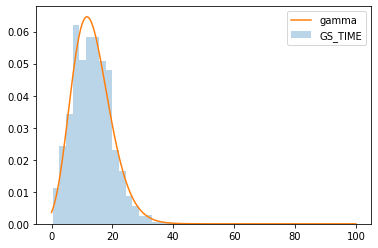

In [25]:
plt.hist(gs_time, bins = 20, density = True,label='GS_TIME', alpha=0.3)
plt.plot(x, y_gs,label='gamma')
plt.legend()

Here is the fit of BKN.

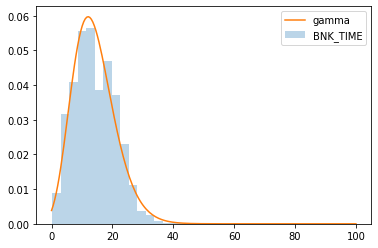

In [26]:
plt.hist(bkn_time, bins = 20, density = True,label='BNK_TIME', alpha=0.3)
plt.plot(x, y_bkn,label='gamma')
plt.legend()

### Run the simmulation

We will run the simulation of the game below.

In [27]:
gs_score_list = []
bkn_score_list = []

In [28]:
for i in range(1000):
    gs_score = 0
    bkn_score = 0
    game_time = 0
    while game_time < 2880:
        game_time = game_time + gamma.rvs(11.381114074215343, -9.342837168485165, 2.0571110740878114)
        bkn_score_diff = (np.random.choice(bkn_ppp_dist.index, p = bkn_ppp_dist.values) + np.random.choice(gs_oppp_dist.index, p = gs_oppp_dist.values))/2
        bkn_score = bkn_score + bkn_score_diff
        game_time = game_time + gamma.rvs(13.699071550059521, -10.203967603863399, 1.7202520490106659)
        gs_score_diff = (np.random.choice(gs_ppp_dist.index, p = gs_ppp_dist.values) + np.random.choice(bkn_oppp_dist.index, p = bkn_oppp_dist.values))/2
        gs_score = gs_score + gs_score_diff
    
    gs_score_list.append(gs_score)
    bkn_score_list.append(bkn_score)

In [29]:
score_diff_list = np.array(bkn_score_list) - np.array(gs_score_list)

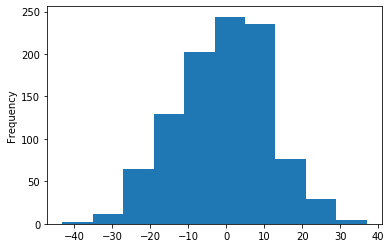

In [30]:
pd.Series(score_diff_list).plot(kind = "hist")

In [31]:
np.count_nonzero(score_diff_list >= 0)/len(score_diff_list)

0.479

It turns out that BKN has 47.9% chance of winning the game.

This is just a draft version. More will be done in the future time.

In [8]:
def calc_dist(away, home, ppp, oppp):
    h_ppp_df = ppp[ppp["Team"] == (home+"*")]
    h_oppp_df = oppp[oppp["Team"] == (home+"*-")]
    a_ppp_df = ppp[ppp["Team"] == away]
    a_oppp_df = oppp[oppp["Team"] == (away+"-")]
    
    h_ppp_dist_2 = h_ppp_df[(h_ppp_df["Time"] <= 2) & (h_ppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    h_ppp_dist_8 = h_ppp_df[(h_ppp_df["Time"] > 2) & (h_ppp_df["Time"] <= 8) & (h_ppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    h_ppp_dist_50 = h_ppp_df[(h_ppp_df["Time"] > 8) & (h_ppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    
    h_oppp_dist_2 = h_oppp_df[(h_oppp_df["Time"] <= 2) & (h_oppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    h_oppp_dist_8 = h_oppp_df[(h_oppp_df["Time"] > 2) & (h_oppp_df["Time"] <= 8) & (h_oppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    h_oppp_dist_50 = h_oppp_df[(h_oppp_df["Time"] > 8) & (h_oppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    
    a_ppp_dist_2 = a_ppp_df[(a_ppp_df["Time"] <= 2) & (a_ppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    a_ppp_dist_8 = a_ppp_df[(a_ppp_df["Time"] > 2) & (a_ppp_df["Time"] <= 8) & (a_ppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    a_ppp_dist_50 = a_ppp_df[(a_ppp_df["Time"] > 8) & (a_ppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    
    a_oppp_dist_2 = a_oppp_df[(a_oppp_df["Time"] <= 2) & (a_oppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    a_oppp_dist_8 = a_oppp_df[(a_oppp_df["Time"] > 2) & (a_oppp_df["Time"] <= 8) & (a_oppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    a_oppp_dist_50 = a_oppp_df[(a_oppp_df["Time"] > 8) & (a_oppp_df["Score"] >= 0)]["Score"].value_counts(normalize = True)
    
    return h_ppp_dist_2,h_ppp_dist_8,h_ppp_dist_50,h_oppp_dist_2,h_oppp_dist_8,h_oppp_dist_50,a_ppp_dist_2,a_ppp_dist_8,a_ppp_dist_50,a_oppp_dist_2,a_oppp_dist_8,a_oppp_dist_50

In [9]:
def simu(away, home, ppp, oppp, n):
    h_time = ppp[ppp["Team"].str.contains(home)]["Time"]
    a_time = ppp[ppp["Team"].str.contains(away)]["Time"]
    h_para = gamma.fit(h_time)
    a_para = gamma.fit(a_time)
    h_score_list = []
    a_score_list = []
    d_list = calc_dist(away, home, ppp, oppp)
    
    for i in range(n):
        h_score = 0
        a_score = 0
        game_time = 0
        while game_time < 2880:
            h_time = gamma.rvs(h_para[0], h_para[1], h_para[2])
            game_time = game_time + h_time
            h_score_diff = 0
            if h_time <= 2:
                h_score_diff = (np.random.choice(d_list[0].index, p = d_list[0].values) + np.random.choice(d_list[9].index, p = d_list[9].values))/2
            elif h_time > 2 and h_time <= 8:
                h_score_diff = (np.random.choice(d_list[1].index, p = d_list[1].values) + np.random.choice(d_list[10].index, p = d_list[10].values))/2
            else:
                h_score_diff = (np.random.choice(d_list[2].index, p = d_list[2].values) + np.random.choice(d_list[11].index, p = d_list[11].values))/2
            
            h_score = h_score + h_score_diff
            
            a_time = gamma.rvs(a_para[0], a_para[1], a_para[2])
            game_time = game_time + a_time
            a_score_diff = 0
            if a_time <= 2:
                a_score_diff = (np.random.choice(d_list[6].index, p = d_list[6].values) + np.random.choice(d_list[3].index, p = d_list[3].values))/2
            elif a_time > 2 and a_time <= 8:
                a_score_diff = (np.random.choice(d_list[7].index, p = d_list[7].values) + np.random.choice(d_list[4].index, p = d_list[4].values))/2
            else:
                a_score_diff = (np.random.choice(d_list[8].index, p = d_list[8].values) + np.random.choice(d_list[5].index, p = d_list[5].values))/2
            
            a_score = a_score + a_score_diff

        h_score_list.append(h_score)
        a_score_list.append(a_score)
    
    return h_score_list, a_score_list

In [10]:
def calc_dist_simple_homedefense(away, home, ppp, oppp):
    h_ppp_df = ppp[ppp["Team"] == (home+"*")]
    h_oppp_df = oppp[oppp["Team"] == (home+"*-")]
    a_ppp_df = ppp[ppp["Team"] == away]
    a_oppp_df = oppp[oppp["Team"] == (away+"-")]
    
    h_ppp_dist = h_ppp_df[h_ppp_df["Score"] >= 0]["Score"].value_counts(normalize = True)
    
    h_oppp_dist = h_oppp_df[h_oppp_df["Score"] >= 0]["Score"].value_counts(normalize = True)
    
    a_ppp_dist = a_ppp_df[a_ppp_df["Score"] >= 0]["Score"].value_counts(normalize = True)
    
    a_oppp_dist = a_oppp_df[a_oppp_df["Score"] >= 0]["Score"].value_counts(normalize = True)
    
    return h_ppp_dist,h_oppp_dist,a_ppp_dist,a_oppp_dist

In [11]:
def simu_simple_homedefense(away, home, ppp, oppp, n):
    h_time = ppp[ppp["Team"].str.contains(home)]["Time"]
    a_time = ppp[ppp["Team"].str.contains(away)]["Time"]
    h_para = gamma.fit(h_time)
    a_para = gamma.fit(a_time)
    h_score_list = []
    a_score_list = []
    d_list = calc_dist_simple_homedefense(away, home, ppp, oppp)
    
    for i in range(n):
        h_score = 0
        a_score = 0
        game_time = 0
        while game_time < 2880:
            h_time = gamma.rvs(h_para[0], h_para[1], h_para[2])
            game_time = game_time + h_time
            h_score_diff = (np.random.choice(d_list[0].index, p = d_list[0].values) + np.random.choice(d_list[3].index, p = d_list[3].values))/2
            h_score = h_score + h_score_diff
            
            a_time = gamma.rvs(a_para[0], a_para[1], a_para[2])
            game_time = game_time + a_time
            a_score_diff = (np.random.choice(d_list[2].index, p = d_list[2].values) + np.random.choice(d_list[1].index, p = d_list[1].values))/2
            a_score = a_score + a_score_diff

        h_score_list.append(h_score)
        a_score_list.append(a_score)
    
    return h_score_list, a_score_list

In [12]:
def calc_dist_simple_no_homedefense(away, home, ppp, oppp):
    h_ppp_df = ppp[ppp["Team"] == (home+"*")]
    h_oppp_df = oppp[oppp["Team"].str.contains(home)]
    a_ppp_df = ppp[ppp["Team"] == away]
    a_oppp_df = oppp[oppp["Team"].str.contains(away)]
    
    h_ppp_dist = h_ppp_df[h_ppp_df["Score"] >= 0]["Score"].value_counts(normalize = True)
    
    h_oppp_dist = h_oppp_df[h_oppp_df["Score"] >= 0]["Score"].value_counts(normalize = True)
    
    a_ppp_dist = a_ppp_df[a_ppp_df["Score"] >= 0]["Score"].value_counts(normalize = True)
    
    a_oppp_dist = a_oppp_df[a_oppp_df["Score"] >= 0]["Score"].value_counts(normalize = True)
    
    return h_ppp_dist,h_oppp_dist,a_ppp_dist,a_oppp_dist

In [13]:
def simu_simple_no_homedefense(away, home, ppp, oppp, n):
    h_time = ppp[ppp["Team"].str.contains(home)]["Time"]
    a_time = ppp[ppp["Team"].str.contains(away)]["Time"]
    h_para = gamma.fit(h_time)
    a_para = gamma.fit(a_time)
    h_score_list = []
    a_score_list = []
    d_list = calc_dist_simple_no_homedefense(away, home, ppp, oppp)
    
    for i in range(n):
        h_score = 0
        a_score = 0
        game_time = 0
        while game_time < 2880:
            h_time = gamma.rvs(h_para[0], h_para[1], h_para[2])
            game_time = game_time + h_time
            h_score_diff = (np.random.choice(d_list[0].index, p = d_list[0].values) + np.random.choice(d_list[3].index, p = d_list[3].values))/2
            h_score = h_score + h_score_diff
            
            a_time = gamma.rvs(a_para[0], a_para[1], a_para[2])
            game_time = game_time + a_time
            a_score_diff = (np.random.choice(d_list[2].index, p = d_list[2].values) + np.random.choice(d_list[1].index, p = d_list[1].values))/2
            a_score = a_score + a_score_diff

        h_score_list.append(h_score)
        a_score_list.append(a_score)
    
    return h_score_list, a_score_list

In [63]:
h_ls, a_ls = simu_simple_homedefense("ATL", "NY", ppp_full, oppp_full, 2000)

In [66]:
h_ls, a_ls = simu("ATL", "NY", ppp_full, oppp_full, 2000)

In [69]:
h_ls, a_ls = simu_simple_no_homedefense("ATL", "NY", ppp_full, oppp_full, 2000)

In [70]:
score_diff_list = np.array(h_ls) - np.array(a_ls)

In [76]:
np.count_nonzero(score_diff_list >= 1)/len(score_diff_list)

0.5095